<h1 style="color:red;">Data Loading, Exploration and Preprocessing</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split
import optuna
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
import joblib

C:\Users\wiemb\SnapReserve\SnapReserve-Backend\venv\Lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
import numpy
import sklearn
import joblib

print("Numpy:", numpy.__version__)
print("scikit-learn:", sklearn.__version__)
print("joblib:", joblib.__version__)


Numpy: 2.3.2
scikit-learn: 1.5.1
joblib: 1.5.1


In [3]:
users = pd.read_csv('synthetic_users.csv') 
events = pd.read_csv('synthetic_events.csv') 
interactions = pd.read_csv('synthetic_interactions.csv')  

print("Users:")
print(users.head())
print("\nEvents:")
print(events.head())
print("\nInteractions:")
print(interactions.head())

Users:
  user_id  gender age_group      role
0  user_0    male     26-35  attendee
1  user_1  female     26-35  attendee
2  user_2    male     26-35  attendee
3  user_3    male     36-50  attendee
4  user_4    male     26-35  attendee

Events:
  event_id category  popularity_score  event_date  is_weekend
0  event_0   Sports              0.96  2025-09-06        True
1  event_1    Movie              0.20  2025-08-04       False
2  event_2    Movie              0.95  2025-07-29       False
3  event_3    Movie              0.99  2025-09-13        True
4  event_4  Theater              0.71  2025-08-14       False

Interactions:
    user_id   event_id
0  user_870  event_209
1  user_101  event_120
2  user_628   event_19
3  user_134  event_127
4   user_57  event_190


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    1003 non-null   object
 1   gender     1003 non-null   object
 2   age_group  1003 non-null   object
 3   role       1003 non-null   object
dtypes: object(4)
memory usage: 31.5+ KB


In [5]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   event_id          517 non-null    object 
 1   category          517 non-null    object 
 2   popularity_score  517 non-null    float64
 3   event_date        517 non-null    object 
 4   is_weekend        517 non-null    bool   
dtypes: bool(1), float64(1), object(3)
memory usage: 16.8+ KB


In [6]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10087 entries, 0 to 10086
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   10087 non-null  object
 1   event_id  10087 non-null  object
dtypes: object(2)
memory usage: 157.7+ KB


<h2>Exploratory Data Analysis (EDA) - Users</h2>

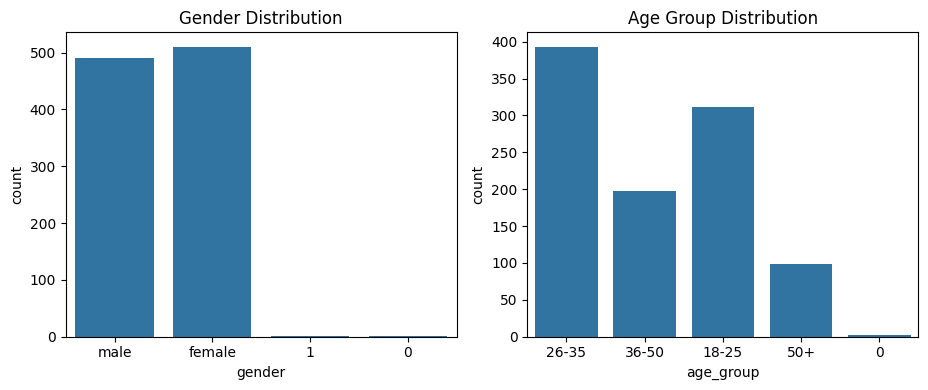

In [7]:
plt.figure(figsize=(14, 4))

plot_idx = 1

if 'gender' in users.columns:
    plt.subplot(1, 3, plot_idx)
    sns.countplot(data=users, x='gender')
    plt.title('Gender Distribution')
    plot_idx += 1

if 'age_group' in users.columns:
    plt.subplot(1, 3, plot_idx)
    sns.countplot(data=users, x='age_group')
    plt.title('Age Group Distribution')
    plot_idx += 1

# if 'role' in users.columns:
#     plt.subplot(1, 3, plot_idx)
#     sns.countplot(data=users, x='role')
#     plt.title('Role Distribution')
    plot_idx += 1

plt.tight_layout()
plt.show()


<h2>Exploratory Data Analysis (EDA) - Events</h2>

Columns in events: Index(['event_id', 'category', 'popularity_score', 'event_date', 'is_weekend'], dtype='object')
Is 'category' column present? True
Events DataFrame empty? False


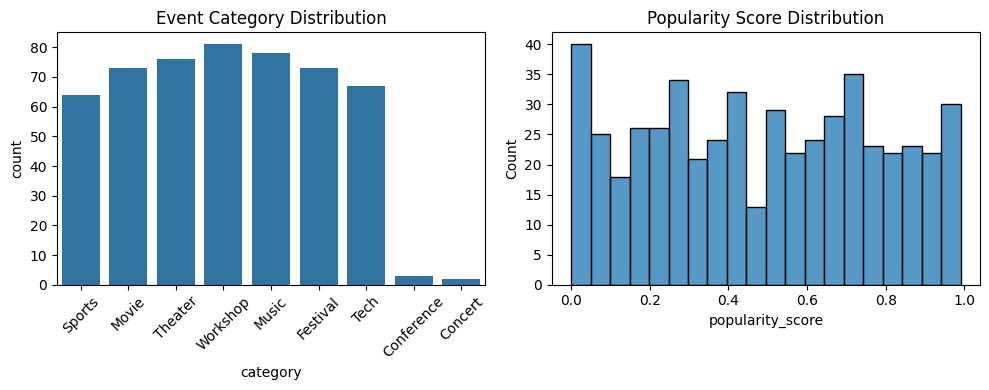

In [8]:
print("Columns in events:", events.columns)
print("Is 'category' column present?", 'category' in events.columns)
print("Events DataFrame empty?", events.empty)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
if 'category' in events.columns and not events.empty:
    sns.countplot(data=events, x='category')
    plt.title('Event Category Distribution')
    plt.xticks(rotation=45)
else:
    print("Skipping countplot: 'category' column missing or events is empty")

plt.subplot(1,2,2)
if not events.empty:
    sns.histplot(data=events, x='popularity_score', bins=20)
    plt.title('Popularity Score Distribution')
else:
    print("Skipping histplot: events DataFrame is empty")

plt.tight_layout()
plt.show()


<h2>Interaction Counts Analysis</h2>

In [9]:
print("\nInteractions per user:")
if 'user_id' in interactions.columns:
    print(interactions['user_id'].value_counts().describe())
else:
    print(" 'user_id' column is missing in interactions.")

print("\nInteractions per event:")
if 'event_id' in interactions.columns:
    print(interactions['event_id'].value_counts().describe())
else:
    print("'event_id' column is missing in interactions.")



Interactions per user:
count    1002.000000
mean       10.066866
std         3.424732
min         2.000000
25%         8.000000
50%        10.000000
75%        12.000000
max        45.000000
Name: count, dtype: float64

Interactions per event:
count    140.000000
mean      72.050000
std       82.600741
min        1.000000
25%        3.000000
50%       31.500000
75%      130.750000
max      289.000000
Name: count, dtype: float64


<h2>Removing uneeded data (users with role organizer )  </h2>

In [10]:
# users = users[users['role'] != 'organizer']
# print(f"Users after removing organizers: {users.shape[0]}")

<h2>Remove interactions related to removed users</h2>

In [11]:
# valid_user_ids = set(users['user_id'])
# interactions = interactions[interactions['user_id'].isin(valid_user_ids)]
# print(f"Interactions after removing organizer-related ones: {interactions.shape[0]}")

<h2>Encode categorical columns</h2>

In [12]:
users_encoded = users.copy()

for col in ['gender', 'age_group', 'role']:
    if col in users.columns:
        users_encoded[col] = users_encoded[col].astype('category').cat.codes
    else:
        print(f"Column '{col}' not found in users DataFrame.")

events_encoded = events.copy()  

if 'category' in events.columns:
    events_encoded['category'] = events_encoded['category'].astype('category').cat.codes
else:
    print("Column 'category' not found in events DataFrame.")

print("\nEncoded Users sample:")
print(users_encoded.head())

print("\nEncoded Events sample:")
print(events_encoded.head())



Encoded Users sample:
  user_id  gender  age_group  role
0  user_0       3          2     1
1  user_1       2          2     1
2  user_2       3          2     1
3  user_3       3          3     1
4  user_4       3          2     1

Encoded Events sample:
  event_id  category  popularity_score  event_date  is_weekend
0  event_0         5              0.96  2025-09-06        True
1  event_1         3              0.20  2025-08-04       False
2  event_2         3              0.95  2025-07-29       False
3  event_3         3              0.99  2025-09-13        True
4  event_4         7              0.71  2025-08-14       False


<h2>Scale popularity_score</h2>

In [13]:
scaler = MinMaxScaler()
events_encoded['popularity_score'] = scaler.fit_transform(events_encoded[['popularity_score']])

<h2>Convert event_date to datetime format</h2>

In [14]:
events_encoded['event_date'] = pd.to_datetime(events_encoded['event_date'])

<h2>Final check: print samples and shapes after cleaning and encoding</h2>

In [15]:
print("\nCleaned Users Sample:")
print(users_encoded.head())

print("\nCleaned Events Sample:")
print(events_encoded.head())

print("\nCleaned Interactions Sample:")
print(interactions.head())


Cleaned Users Sample:
  user_id  gender  age_group  role
0  user_0       3          2     1
1  user_1       2          2     1
2  user_2       3          2     1
3  user_3       3          3     1
4  user_4       3          2     1

Cleaned Events Sample:
  event_id  category  popularity_score event_date  is_weekend
0  event_0         5          0.969697 2025-09-06        True
1  event_1         3          0.202020 2025-08-04       False
2  event_2         3          0.959596 2025-07-29       False
3  event_3         3          1.000000 2025-09-13        True
4  event_4         7          0.717172 2025-08-14       False

Cleaned Interactions Sample:
    user_id   event_id
0  user_870  event_209
1  user_101  event_120
2  user_628   event_19
3  user_134  event_127
4   user_57  event_190


<h1 style="color:red;">LightFM Dataset Preparation</h1>

<h2>Build interaction matrix from (user_id, event_id) pairs</h2> 

In [16]:
dataset = Dataset()

user_ids = users_encoded['user_id'].unique()
event_ids = events_encoded['event_id'].unique()

user_features_raw = users_encoded.set_index('user_id')[['gender', 'age_group', 'role']]
user_feature_tuples = [
    (uid, [f"gender:{g}", f"age_group:{a}", f"role:{r}"])
    for uid, g, a, r in zip(user_features_raw.index, user_features_raw['gender'], user_features_raw['age_group'], user_features_raw['role'])
]

event_features_raw = events_encoded.set_index('event_id')[['category', 'popularity_score', 'is_weekend']]
event_feature_tuples = [
    (eid, [f"category:{c}", f"is_weekend:{w}"])
    for eid, c, w in zip(event_features_raw.index, event_features_raw['category'], event_features_raw['is_weekend'])
]

dataset.fit(
    users=user_ids,
    items=event_ids,
    user_features=set(f for _, feats in user_feature_tuples for f in feats),
    item_features=set(f for _, feats in event_feature_tuples for f in feats)
)

(interactions_matrix, weights) = dataset.build_interactions(
    [(row['user_id'], row['event_id']) for idx, row in interactions.iterrows()]
)
print(f"Interaction matrix shape: {interactions_matrix.shape}")

user_features = dataset.build_user_features(user_feature_tuples)
item_features = dataset.build_item_features(event_feature_tuples)

print("User features sparse:", user_features.shape)
print("Item features sparse:", item_features.shape)


Interaction matrix shape: (1002, 506)
User features sparse: (1002, 1014)
Item features sparse: (506, 517)


<h1 style="color:red;">Training</h1>

<h2>Train-Test Split</h2>

In [17]:
train, test = random_train_test_split(interactions_matrix, test_percentage=0.2, random_state=42)
print(f"Train interactions: {train.nnz} | Test interactions: {test.nnz}")

Train interactions: 8069 | Test interactions: 2018


<h2>Hyperparameter Tuning with Optuna</h2>
<p>We use Optuna to automatically and efficiently find the best hyperparameters for the LightFM model. Optuna intelligently explores the parameter space by learning from previous trials, allowing faster convergence to optimal values compared to manual or random searches. This results in improved model performance with fewer training iterations and less computational effort.</p>

In [18]:
def objective(trial):

    model = LightFM(
        no_components=trial.suggest_int("no_components", 20, 100),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        item_alpha=trial.suggest_float("item_alpha", 1e-6, 1e-2, log=True),
        user_alpha=trial.suggest_float("user_alpha", 1e-6, 1e-2, log=True),
        loss="logistic",
        random_state=42
    )

 
    model.fit(train,
              user_features=user_features,
              item_features=item_features,
              epochs=20,
              num_threads=4,
              verbose=False)


    precision = precision_at_k(model, test,
                               user_features=user_features,
                               item_features=item_features,
                               k=5).mean()
    return precision


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best parameters:", study.best_params)
print("Best Precision@5:", study.best_value)

[I 2025-08-13 23:45:17,926] A new study created in memory with name: no-name-e0772a50-c75c-47d7-a9d2-895410915403


[I 2025-08-13 23:45:19,560] Trial 0 finished with value: 0.03421354666352272 and parameters: {'no_components': 30, 'learning_rate': 0.08946284458979986, 'item_alpha': 1.5386629176102066e-06, 'user_alpha': 0.00011733457943544137}. Best is trial 0 with value: 0.03421354666352272.


[I 2025-08-13 23:45:22,339] Trial 1 finished with value: 0.03582089766860008 and parameters: {'no_components': 72, 'learning_rate': 0.007257159124165562, 'item_alpha': 1.9626087749240455e-06, 'user_alpha': 1.2320717781888457e-06}. Best is trial 1 with value: 0.03582089766860008.


[I 2025-08-13 23:45:25,676] Trial 2 finished with value: 0.03582089766860008 and parameters: {'no_components': 96, 'learning_rate': 0.0018222091651625455, 'item_alpha': 3.994365291006628e-06, 'user_alpha': 0.001458916273870381}. Best is trial 1 with value: 0.03582089766860008.


[I 2025-08-13 23:45:27,762] Trial 3 finished with value: 0.03582089766860008 and parameters: {'no_components': 72, 'learning_rate': 0.0013285199188441787, 'item_alpha': 0.0012148035217734849, 'user_alpha': 0.0009147917426815152}. Best is trial 1 with value: 0.03582089766860008.


[I 2025-08-13 23:45:29,308] Trial 4 finished with value: 0.02365097589790821 and parameters: {'no_components': 43, 'learning_rate': 0.009014854359607007, 'item_alpha': 0.009000463336410951, 'user_alpha': 6.092420669449027e-05}. Best is trial 1 with value: 0.03582089766860008.


[I 2025-08-13 23:45:30,649] Trial 5 finished with value: 0.03467278927564621 and parameters: {'no_components': 53, 'learning_rate': 0.07689797923583014, 'item_alpha': 1.4728616870957237e-05, 'user_alpha': 0.00545636750023616}. Best is trial 1 with value: 0.03582089766860008.


[I 2025-08-13 23:45:32,394] Trial 6 finished with value: 0.04064293950796127 and parameters: {'no_components': 39, 'learning_rate': 0.0003819695080423711, 'item_alpha': 0.0028211508255288394, 'user_alpha': 2.4584274676036623e-05}. Best is trial 6 with value: 0.04064293950796127.


[I 2025-08-13 23:45:34,757] Trial 7 finished with value: 0.03673937916755676 and parameters: {'no_components': 55, 'learning_rate': 0.00014581114748341107, 'item_alpha': 5.614580491120412e-05, 'user_alpha': 0.00017458725276971887}. Best is trial 6 with value: 0.04064293950796127.


[I 2025-08-13 23:45:37,532] Trial 8 finished with value: 0.03467278927564621 and parameters: {'no_components': 75, 'learning_rate': 0.01879834114773411, 'item_alpha': 0.00017703914311580473, 'user_alpha': 0.0010543814899215435}. Best is trial 6 with value: 0.04064293950796127.


[I 2025-08-13 23:45:40,637] Trial 9 finished with value: 0.03467278927564621 and parameters: {'no_components': 85, 'learning_rate': 0.05229367728514676, 'item_alpha': 2.077618706985727e-06, 'user_alpha': 0.0003163494274800313}. Best is trial 6 with value: 0.04064293950796127.


[I 2025-08-13 23:45:41,781] Trial 10 finished with value: 0.04247990995645523 and parameters: {'no_components': 21, 'learning_rate': 0.0002432630102821643, 'item_alpha': 0.009445537720484662, 'user_alpha': 8.87951381846164e-06}. Best is trial 10 with value: 0.04247990995645523.


[I 2025-08-13 23:45:42,834] Trial 11 finished with value: 0.038346730172634125 and parameters: {'no_components': 20, 'learning_rate': 0.00017921068956041554, 'item_alpha': 0.007809093286441369, 'user_alpha': 9.638002650066955e-06}. Best is trial 10 with value: 0.04247990995645523.


[I 2025-08-13 23:45:44,376] Trial 12 finished with value: 0.044087257236242294 and parameters: {'no_components': 36, 'learning_rate': 0.0005397677532603222, 'item_alpha': 0.001295008674823881, 'user_alpha': 1.1997068282637354e-05}. Best is trial 12 with value: 0.044087257236242294.


[I 2025-08-13 23:45:45,287] Trial 13 finished with value: 0.04477611929178238 and parameters: {'no_components': 20, 'learning_rate': 0.0005720620365020681, 'item_alpha': 0.0005247306002117799, 'user_alpha': 4.045077545435289e-06}. Best is trial 13 with value: 0.04477611929178238.


[I 2025-08-13 23:45:46,507] Trial 14 finished with value: 0.03582089766860008 and parameters: {'no_components': 34, 'learning_rate': 0.0005562123912094147, 'item_alpha': 0.00045628471123586447, 'user_alpha': 1.5584407680149775e-06}. Best is trial 13 with value: 0.04477611929178238.


[I 2025-08-13 23:45:48,292] Trial 15 finished with value: 0.03467278927564621 and parameters: {'no_components': 47, 'learning_rate': 0.0008942601860771354, 'item_alpha': 0.0007927828666561146, 'user_alpha': 4.598290979691709e-06}. Best is trial 13 with value: 0.04477611929178238.


[I 2025-08-13 23:45:49,330] Trial 16 finished with value: 0.03582089766860008 and parameters: {'no_components': 29, 'learning_rate': 0.0034481533810401988, 'item_alpha': 0.00017781155980743472, 'user_alpha': 2.4466886424119618e-05}. Best is trial 13 with value: 0.04477611929178238.


[I 2025-08-13 23:45:50,431] Trial 17 finished with value: 0.04247990995645523 and parameters: {'no_components': 27, 'learning_rate': 0.00010865806258533098, 'item_alpha': 6.650551396970569e-05, 'user_alpha': 3.7748222543654146e-06}. Best is trial 13 with value: 0.04477611929178238.


[I 2025-08-13 23:45:52,548] Trial 18 finished with value: 0.03467278927564621 and parameters: {'no_components': 63, 'learning_rate': 0.0005308937519033054, 'item_alpha': 0.0020750819618442313, 'user_alpha': 2.4358256170475176e-05}. Best is trial 13 with value: 0.04477611929178238.


[I 2025-08-13 23:45:54,171] Trial 19 finished with value: 0.03467278927564621 and parameters: {'no_components': 38, 'learning_rate': 0.002115232322030853, 'item_alpha': 0.00040210710778951946, 'user_alpha': 2.920932822844277e-06}. Best is trial 13 with value: 0.04477611929178238.


Best parameters: {'no_components': 20, 'learning_rate': 0.0005720620365020681, 'item_alpha': 0.0005247306002117799, 'user_alpha': 4.045077545435289e-06}
Best Precision@5: 0.04477611929178238


<h2> Train Final Model with Best Parameters</h2>

In [19]:
best_params = study.best_params
model = LightFM(**best_params, random_state=42)

model.fit(train,
          user_features=user_features,
          item_features=item_features,
          epochs=20,
          num_threads=4)

<h1 style="color:red;">Evaluation</h1>
<ol>
    <li> <b>Precision@5: 0.0541</b>
This means that, on average, about 5.4% of the top 5 recommendations for a user are relevant or actually interacted with by the user. It reflects the accuracy of the top recommendations.</li>
    <li> <b>Recall@5: 0.1214</b>
This indicates that the system is able to retrieve around 12.1% of all relevant items (items the user interacted with) within the top 5 recommendations. It shows how well the system covers the user’s interests.</li>
    <li><b> AUC Score: 0.7430</b>
       
The Area Under the Curve (AUC) score of 0.743 means the model has a good overall ability to distinguish between items a user will interact with and those they will not. A score closer to 1 is better, so 0.743 shows solid predictive performance.

</li>
</ol>

In [20]:
precision = precision_at_k(model, test,
                           user_features=user_features,
                           item_features=item_features,
                           k=5).mean()
recall = recall_at_k(model, test,
                     user_features=user_features,
                     item_features=item_features,
                     k=5).mean()
auc = auc_score(model, test,
                user_features=user_features,
                item_features=item_features).mean()

print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")
print(f"AUC Score: {auc:.4f}")


Precision@5: 0.0448
Recall@5: 0.0918
AUC Score: 0.7238


<h2>Generate Top-N Recommendations</h2>

In [21]:
def generate_recommendations(model, user_ids, interactions_matrix, user_features, item_features, n=5):
    n_users, n_items = interactions_matrix.shape
    recommendations = {}

    for user_idx in range(n_users):
        scores = model.predict(user_ids=user_idx,
                               item_ids=np.arange(n_items),
                               user_features=user_features,
                               item_features=item_features)

        known_items = interactions_matrix.tocsr()[user_idx].indices
        scores[known_items] = -np.inf 

        top_items = np.argsort(-scores)[:n]
        recommendations[user_ids[user_idx]] = top_items

    return recommendations

<h2>Mapping & Displaying Recommendations (for user with id 0 )</h2> <p>this is used to have a better insight about the recommendation performance and the pattern followed</p>

In [22]:
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()
inv_user_id_map = {v: k for k, v in user_id_map.items()}
real_user_id = inv_user_id_map[0]
print(f"Internal user ID 0 corresponds to user_id: {real_user_id}")
user_interactions = interactions[interactions['user_id'] == real_user_id]
print("Events user interacted with:")
print(user_interactions)
interacted_event_info = user_interactions.merge(events, on='event_id', how='left')
print(interacted_event_info)

Internal user ID 0 corresponds to user_id: user_0
Events user interacted with:
     user_id   event_id
61    user_0   event_99
1310  user_0  event_310
2927  user_0  event_405
3228  user_0  event_199
3373  user_0  event_355
5340  user_0  event_127
7251  user_0   event_19
7598  user_0  event_269
9849  user_0  event_269
  user_id   event_id  category  popularity_score  event_date  is_weekend
0  user_0   event_99      Tech              0.94  2025-08-10        True
1  user_0  event_310      Tech              0.98  2025-08-01       False
2  user_0  event_405      Tech              0.91  2025-08-26       False
3  user_0  event_199    Sports              0.97  2025-09-14        True
4  user_0  event_355      Tech              0.92  2025-09-17       False
5  user_0  event_127  Workshop              0.97  2025-07-31       False
6  user_0   event_19    Sports              0.98  2025-08-02        True
7  user_0  event_269  Workshop              0.97  2025-09-01       False
8  user_0  event_269  Wo

<h2>Exploring Recommendation Diversity and Novelty</h2> <p>To evaluate the quality of our recommendation system beyond accuracy, we analyze how diverse (varied) and serendipitous (unexpected but relevant) the suggested items are. This helps ensure users receive a mix of familiar and novel content that keeps the experience engaging and personalized.</p>
<ol>
    <li>A lower value of Diversity means less variation in content types.
</li>
<li>A high Serendipity score means that many of the recommended items are new to the user and highly popular, indicating that the system is effectively introducing appealing and unexpected content.</li>
</ol>

In [23]:
def get_recommendations_for_user(user_id, model, dataset, user_features, item_features, events_df, top_n=10):
    user_mapping = dataset.mapping()[0]
    event_mapping = dataset.mapping()[2] 
    inv_event_mapping = {v: k for k, v in event_mapping.items()}

    if user_id not in user_mapping:
        raise ValueError(f"User {user_id} not in dataset.")

    user_internal_id = user_mapping[user_id]

    scores = model.predict(user_internal_id, np.arange(len(event_mapping)), user_features=user_features, item_features=item_features)

    top_items_idx = np.argsort(-scores)[:top_n]
    
    recommended_event_ids = [inv_event_mapping[i] for i in top_items_idx]

    return recommended_event_ids, scores[top_items_idx]

In [24]:
# Set the user ID to test
test_user_id = "user_0"

# Call the function
try:
    recommended_ids, scores = get_recommendations_for_user(
        user_id=test_user_id,
        model=model,
        dataset=dataset,
        user_features=user_features,
        item_features=item_features,
        events_df=events_encoded,  
        top_n=5
    )

    print("Recommended Event IDs:", recommended_ids)
    print("Scores:", scores)

except ValueError as e:
    print("Error:", e)


Recommended Event IDs: ['cmeabrglu000jgbzgn6sy3za4', 'event_5', 'event_177', 'event_120', 'event_17']
Scores: [0.6060961  0.55221695 0.5503636  0.55007374 0.5498514 ]


In [25]:

def diversity(recommendations, events_df):
    categories = events_df[events_df['event_id'].isin(recommendations)]['category']
    if len(categories) == 0:
        return 0
    return categories.nunique() / len(categories)

In [26]:
def serendipity(recommendations, user_history, events_df):
    novel_items = set(recommendations) - set(user_history)
    if len(recommendations) == 0:
        return 0
    top_serendipitous = events_df[
        (events_df['event_id'].isin(novel_items)) & 
        (events_df['popularity_score'] > 0.9)
    ]
    return len(top_serendipitous) / len(recommendations)

In [27]:
user_to_test = 'user_0'

user_history = interactions[interactions['user_id'] == user_to_test]['event_id'].tolist()

recommended_events, rec_scores = get_recommendations_for_user(
    user_id=user_to_test,
    model=model,
    dataset=dataset,
    user_features=user_features,
    item_features=item_features,
    events_df=events_encoded,
    top_n=10
)

div_score = diversity(recommended_events, events_encoded)
ser_score = serendipity(recommended_events, user_history, events_encoded)

print(f"Recommendations for {user_to_test}: {recommended_events}")
print(f"Diversity: {div_score:.3f}")
print(f"Serendipity: {ser_score:.3f}")


Recommendations for user_0: ['cmeabrglu000jgbzgn6sy3za4', 'event_5', 'event_177', 'event_120', 'event_17', 'cmeabw1zm000tgbzgsx6yltft', 'event_141', 'event_2', 'event_310', 'event_451']
Diversity: 0.176
Serendipity: 0.700


<h2>Export the model</h2>

In [28]:
joblib.dump(model, 'recommendation_model.pkl')
joblib.dump(scaler, 'recommendation_scaler.pkl')
joblib.dump(user_features, 'recommendation_user_features.pkl')
joblib.dump(item_features, 'recommendation_item_features.pkl')
joblib.dump(dataset, 'recommendation_dataset.pkl')


['recommendation_dataset.pkl']